In [1]:
import lightning.pytorch as pl
import torch
import torch.nn as nn
from datasets import load_dataset, load_from_disk
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [2]:
### Load Dataset

In [3]:
ds = load_dataset("stanfordnlp/imdb")
labels = {"0": "neg", "1": "pos"}

In [4]:
### Tokenize
from src.tokenize.tokenizer import Tokenizer

TOKENIZER_CHECKPOINT = (
    "/home/pranav-pc/projects/OpenTransformer/multiformer/tokenizer_checkpoints/"
)
tokenizer = Tokenizer(TOKENIZER_CHECKPOINT)

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
ds = ds.map(
    lambda example: {"token_ids": tokenizer.encode_as_ids(example["text"])},
    batch_size=int(5e3),
    batched=True,
    num_proc=25,
    remove_columns=["text"],
)

Map (num_proc=25):   0%|          | 0/25000 [00:00<?, ? examples/s]

Map (num_proc=25):   0%|          | 0/25000 [00:00<?, ? examples/s]

Map (num_proc=25):   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
ds = ds.map(lambda example: {"len": len(example["token_ids"])})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

<Axes: ylabel='Density'>

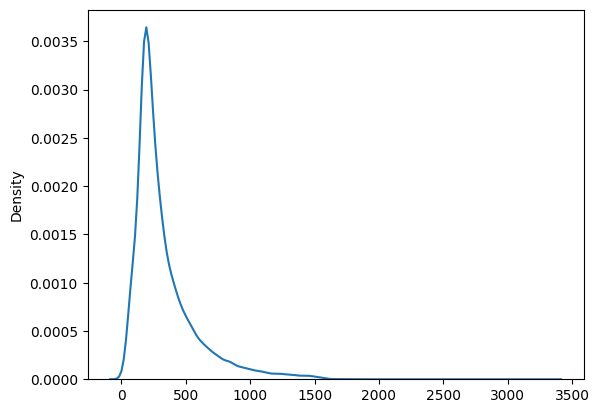

In [8]:
import seaborn as sns

sns.kdeplot(ds["test"]["len"])

In [10]:
ds = ds.map(lambda example: {"idx": example["token_ids"][:512]})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

<Axes: ylabel='Density'>

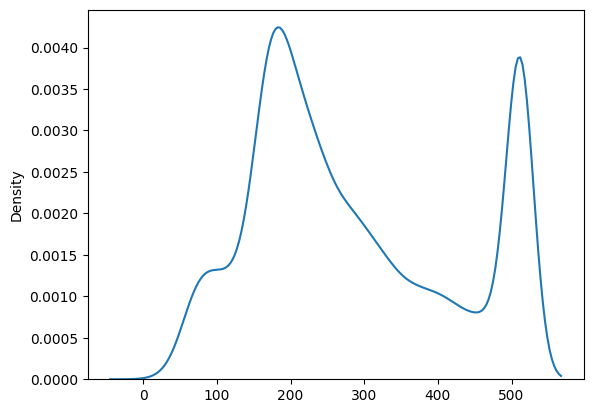

In [13]:
ds = ds.map(lambda example: {"len": len(example["idx"])})
import seaborn as sns

sns.kdeplot(ds["test"]["len"])

In [ ]:
class IMDBDataLoader(pl.LightningDataModule):
    def __init__(self, dataset_path, tokenizer_path, batch_size, num_workers):
        super().__init__()
        self.dataset_path = dataset_path

        self.batch_size = batch_size
        self.num_workers = num_workers

        self.tokenizer = self._load_tokenizer(tokenizer_path)

    def prepare_data(self):
        self.ds = load_dataset(self.dataset_path)

    @staticmethod
    def _load_tokenizer(tokenizer_path):
        from src.tokenize.tokenizer import Tokenizer

        return Tokenizer(tokenizer_path)

    def _collate_fn(self, batch: int, padding_id: int):
        x, y = batch
        x = pad_sequence(
            x,
            batch_first=True,
            padding_value=padding_id,
        )
        x = torch.tensor(x, dtype=torch.LongTensor)
        y = torch.tensor(y)
        return x, y

    def setup(self, stage):

        self.train_data = self.ds["train"]
        self.val_data = self.ds["unsupervised"]
        self.test_data = self.ds["test"]

    def train_dataloader(self):
        return DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self._collate_fn,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self._collate_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.val_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self._collate_fn,
        )

In [1]:
# https://huggingface.co/datasets/berkeley-nest/Nectar

# https://huggingface.co/datasets/allenai/ultrafeedback_binarized_cleaned

# https://huggingface.co/datasets/Open-Orca/SlimOrca

# https://huggingface.co/datasets/Intel/orca_dpo_pairs

# https://huggingface.co/datasets/teknium/openhermes

# https://huggingface.co/datasets/athirdpath/DPO_Pairs-Roleplay-Alpaca-NSFW

# https://huggingface.co/datasets/meta-math/MetaMathQA


# # Alpaca, Slim Orca, OASST, Platypus, Norobots

In [ ]:
dataset_path = "stanfordnlp/imdb"